### Il notebook implementa un approccio non supervisionato per la classificazione e genera tramite gli embeddings pretrainati un lessico dal quale estrarre i sentiment score. La metodologia è discussa nel report.

In [1]:
import pandas as pd
import nltk
import numpy as np
import string
import gensim
from sklearn.pipeline import Pipeline
from preprocessing import *
from numpy import array 
from numpy import dot
from numpy.linalg import norm

In [2]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases

In [3]:
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import wordnet
import re

In [4]:
dataset = pd.read_csv("amazon_alexa.tsv", sep = "\t", encoding = "utf-8")
print(dataset.shape)
dataset.dropna(inplace = True)
print(dataset.shape)
dataset.drop(dataset[dataset.rating == 3].index, inplace=True)
print(dataset.shape)
dataset.drop_duplicates(subset = "verified_reviews", inplace = True)
print(dataset.shape)

(3150, 6)
(3150, 6)
(2998, 6)
(2196, 6)


In [5]:
w2v_model = Word2Vec.load("w2vPreTrained")

In [6]:
w2v_model.wv.most_similar(['love'], topn = 10)

[('enjoy', 0.5578348636627197),
 ('great', 0.5526167154312134),
 ('amaze', 0.5221312046051025),
 ('like', 0.4955675005912781),
 ('awesome', 0.43842583894729614),
 ('favorite', 0.42576074600219727),
 ('fun', 0.4234786629676819),
 ('amazing', 0.4115583598613739),
 ('fantastic', 0.408966600894928),
 ('nice', 0.3966287672519684)]

In [7]:
w2v_model.wv.most_similar(['love'], topn = len(w2v_model.wv.vectors))[-10:] # less similar words

[('may', -0.3007705509662628),
 ('not_internet', -0.3016756474971771),
 ('not_drop', -0.30507779121398926),
 ('hype', -0.3121069371700287),
 ('tight', -0.31214627623558044),
 ('not_voice', -0.3136102557182312),
 ('crash', -0.3138749599456787),
 ('not_ready', -0.3269640803337097),
 ('not_sync', -0.33947843313217163),
 ('processor', -0.37799587845802307)]

In [8]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statistics 
#from plotnine import *
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import cosine_similarity

from kneed import KneeLocator

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer


#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [9]:
words_wv = w2v_model.wv.index_to_key
len(words_wv)

3454

In [10]:
# calcola SSE e Silhuette per valutare il parametro k del k-means
sse_list = []
silhouette_list = []
for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
    kmeans.fit(w2v_model.wv.vectors)
    sse_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(w2v_model.wv.vectors,kmeans.labels_))

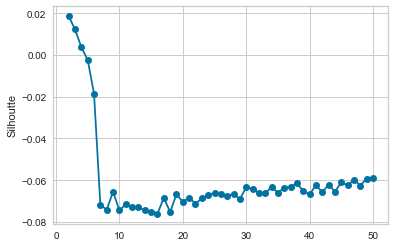

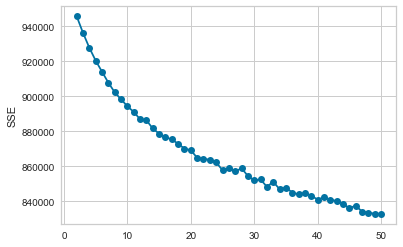

In [11]:
plt.plot(range(2, len(silhouette_list)+2), silhouette_list, marker='o')
plt.ylabel('Silhoutte')
plt.show()
plt.plot(range(2, len(sse_list)+2), sse_list, marker='o')
plt.ylabel('SSE')
plt.show()

In [16]:
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=300)
kmeans.fit(w2v_model.wv.vectors)

KMeans(n_clusters=5)

In [17]:
centers=kmeans.cluster_centers_ # centroidi
labels=kmeans.labels_ # clusters labels
np.unique(labels, return_counts=True) 

(array([0, 1, 2, 3, 4]), array([ 562,  694, 1064,  402,  732], dtype=int64))

In [18]:
len(centers)

5

In [15]:
for i in centers:
    print(w2v_model.wv.most_similar(i, topn=40))
    print("####################################################")

[('equivalent', 0.47151029109954834), ('already', 0.43056100606918335), ('standalone', 0.3873092830181122), ('infotainment', 0.3782343566417694), ('redundant', 0.3734094500541687), ('bell_whistle', 0.3667634427547455), ('consider', 0.36130979657173157), ('membership', 0.35279521346092224), ('invest', 0.3479014039039612), ('build', 0.34558743238449097), ('comparable', 0.34545502066612244), ('tether', 0.3423275947570801), ('limited', 0.3412395715713501), ('lack', 0.3326011300086975), ('smarter', 0.3325844407081604), ('market', 0.33152034878730774), ('compete', 0.33079448342323303), ('cheap', 0.33035364747047424), ('brainer', 0.3300340473651886), ('exist', 0.32598960399627686), ('cost', 0.3253600299358368), ('affordable', 0.3249719440937042), ('ultimate', 0.3224535882472992), ('skeptical', 0.32004350423812866), ('available', 0.3198855519294739), ('transmitter', 0.3196362555027008), ('segregate', 0.3190455734729767), ('versatile', 0.31873229146003723), ('offer', 0.3185325562953949), ('volv

In [19]:
df = pd.DataFrame()

In [21]:
print(len(w2v_model.wv["love"]))
print(len(centers[0])) # to check if the vectors have the same length

100
100


In [22]:
words = []
labels = []
cos = []
for w, label in zip(words_wv, kmeans.labels_):
    # this calculates the similarity bewtween centroids and all the words in their clusters
    try:
        cos_sim = dot(w2v_model.wv[w], centers[label])/(norm(w2v_model.wv[w])*norm(centers[label])) # cosine similarity formula (dot(a, b)/norm(a)*norm(b))
    except:
        continue
    words.append(w)
    labels.append(label)
    cos.append(cos_sim)
    
df["word"] = words
df["labels"] = labels
df["cos"] = cos

print(df[df["labels"] == 1].sort_values(by = "cos", ascending = False).to_markdown()) # shows the most similar words to that cluster

|      | word           |   labels |        cos |
|-----:|:---------------|---------:|-----------:|
|  209 | kid            |        1 | 0.507033   |
|  489 | joke           |        1 | 0.455718   |
|   65 | tell           |        1 | 0.452636   |
|  483 | mom            |        1 | 0.445218   |
| 2755 | comfort        |        1 | 0.44162    |
|  286 | reminder       |        1 | 0.437656   |
| 1246 | grandkids      |        1 | 0.427547   |
| 2945 | bible          |        1 | 0.41344    |
|  510 | shopping_list  |        1 | 0.41193    |
|  756 | dog            |        1 | 0.404975   |
|  119 | weather        |        1 | 0.403101   |
|  428 | daughter       |        1 | 0.402966   |
| 2490 | animal         |        1 | 0.398813   |
| 2785 | football       |        1 | 0.398211   |
| 2927 | buddy          |        1 | 0.395103   |
| 3244 | med            |        1 | 0.39211    |
|  253 | favorite       |        1 | 0.387793   |
| 2513 | medication     |        1 | 0.387262   |


In [23]:
from sklearn.manifold import TSNE

In [25]:
# dimensionality reduction a 3 dimensioni per plottare
tsne = TSNE(3, learning_rate="auto", metric="cosine")
tokens_list = []
for vec in w2v_model.wv.vectors:
    tokens_list.append(vec)

In [26]:
new_val = tsne.fit_transform(np.array(tokens_list))

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [27]:
df["x"] = [x[0] for x in new_val]
df["y"] = [x[1] for x in new_val]
df["z"] = [x[2] for x in new_val]

In [28]:
import seaborn as sns

<AxesSubplot:xlabel='x', ylabel='y'>

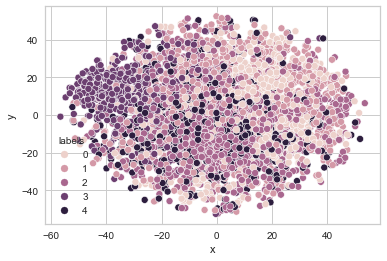

In [29]:
sns.scatterplot(data = df, x = "x", y = "y", hue = "labels")

In [30]:
import plotly_express as px

In [54]:
px.scatter_3d(data_frame = df, x = "x", y = "y", z = "z", hover_name = "word")

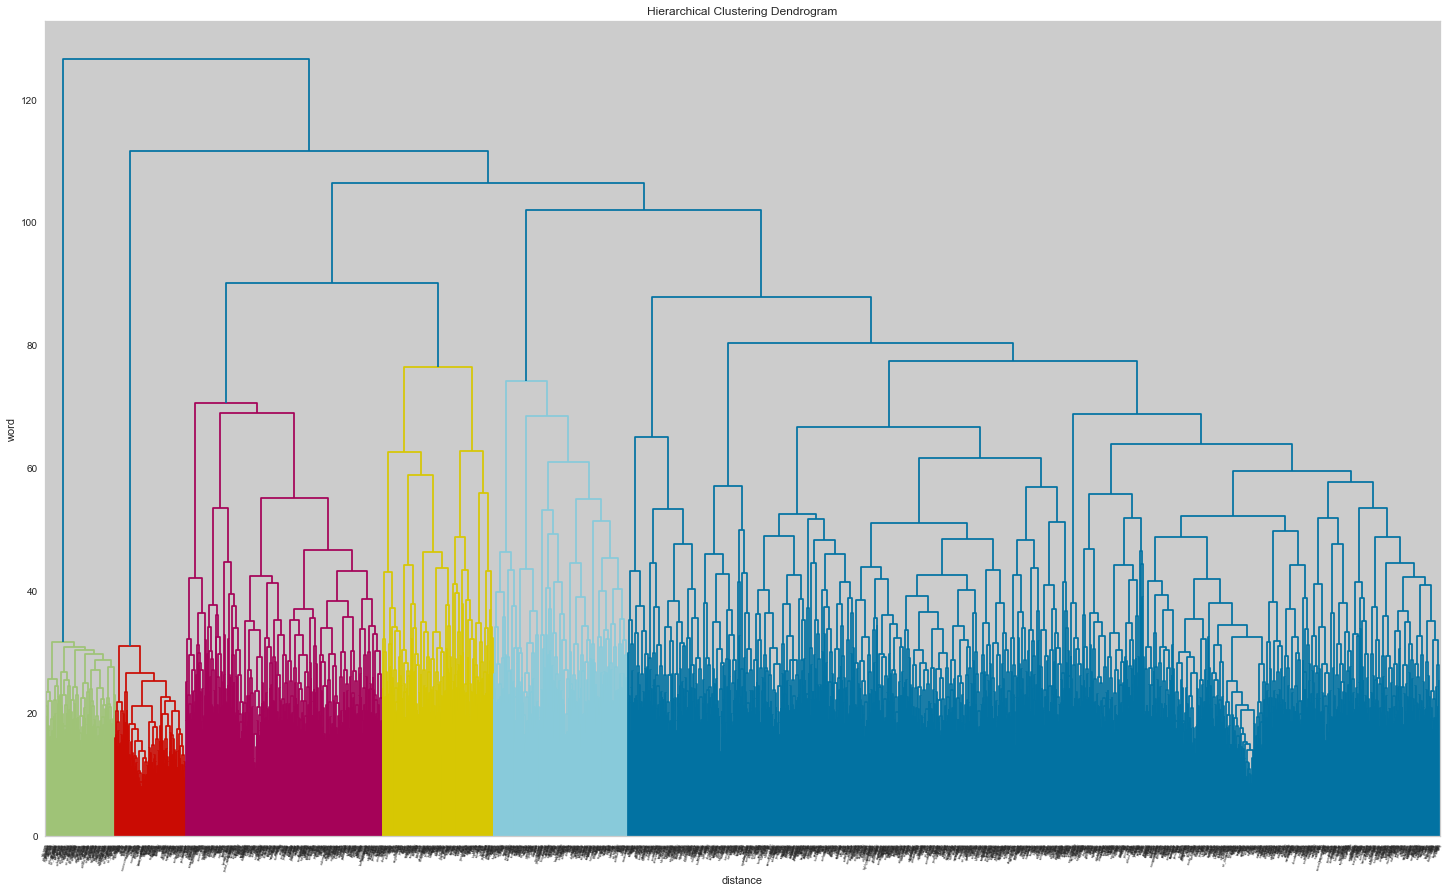

In [32]:
# distance_matrix = pairwise_distances(vectors, vectors, metric = "cosine")
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

l = linkage(w2v_model.wv.vectors, method='ward', metric='euclidean')

# calculate full dendrogram
plt.figure(figsize=(25, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=75.,  # rotates the x axis labels
    leaf_font_size=3.,  # font size for the x axis labels
    leaf_label_func=lambda v: str(w2v_model.wv.index_to_key[v])
)
plt.show()

In [33]:
hier_df = pd.DataFrame()

hier_labels = fcluster(l, 6, "maxclust")
hier_df["labels"] = hier_labels

hier_df["x"] = df["x"]
hier_df["y"] = df["y"]
hier_df["z"] = df["z"]
hier_df["word"] = df["word"]
print(hier_df[hier_df["labels"] == 1].to_markdown())

|      |   labels |          x |          y |           z | word              |
|-----:|---------:|-----------:|-----------:|------------:|:------------------|
|  344 |        1 | -40.7885   |  11.419    |   5.89392   | not_sure          |
|  490 |        1 | -43.2869   |   8.11955  | -13.1583    | not_work          |
|  551 |        1 | -46.5358   |  18.4788   |   6.92923   | not_use           |
|  624 |        1 | -45.2141   |  10.5674   |   5.453     | not_good          |
|  787 |        1 | -50.4672   |  16.3511   |   3.30789   | not_able          |
|  791 |        1 | -35.7665   |  17.5024   |  -4.34035   | not_get           |
|  814 |        1 | -41.3177   |  14.2585   |   0.936869  | not_connect       |
|  817 |        1 | -32.1884   |   8.66648  | -13.3293    | not_much          |
|  832 |        1 | -47.7177   |  16.3504   |   8.09089   | not_like          |
|  850 |        1 | -37.7263   |  27.5341   |   3.55174   | not_great         |
|  912 |        1 | -50.0888   |  19.791

In [34]:
px.scatter_3d(data_frame = hier_df, x = "x", y = "y", z = "z", color = [str(x) for x in hier_df["labels"]], hover_name = "word")

In [35]:
target_pos = ["love", "awesome", "nice",
"amazing", "best", "fantastic", "correct", "happy"
]

target_neg = ["hate", "terrible", "nasty", "awful",
"worst", "horrible"]

In [36]:
pos_average_vector = np.zeros(w2v_model.vector_size).reshape((w2v_model.vector_size, ))
neg_average_vector = np.zeros(w2v_model.vector_size).reshape((w2v_model.vector_size, ))
for word in target_pos:
    try:
        pos_average_vector += w2v_model.wv[word]
    except KeyError:
        continue
for word in target_neg:
    try:
        neg_average_vector += w2v_model.wv[word]
    except KeyError:
        continue

pos_average_vector = pos_average_vector / norm(pos_average_vector)
neg_average_vector = neg_average_vector / norm(neg_average_vector)

semantic_axe = pos_average_vector - neg_average_vector

In [37]:
df_polarity = pd.DataFrame()

words = []
scores = []

for w in words_wv:
    words.append(w)
    score = dot(w2v_model.wv[w], semantic_axe)/(norm(w2v_model.wv[w])*norm(semantic_axe))
    scores.append(score)

df_polarity["word"] = words
df_polarity["score"] = scores

df_polarity.sort_values(by = "score", ascending = True).head(10)

,word,score
993,horrible,-0.447070
1344,awful,-0.437519
3375,afterwards,-0.391189
1585,unresponsive,-0.388564
704,hate,-0.342750
1023,seriously,-0.330945
283,microphone,-0.328395
1661,headache,-0.324527
180,bad,-0.322235
3317,questionable,-0.320123


In [59]:
print(df_polarity.sort_values(by = "score", ascending = False).head(10).to_latex(index = False))

\begin{tabular}{lr}
\toprule
      word &    score \\
\midrule
     happy & 0.520724 \\
 fantastic & 0.500865 \\
     great & 0.455940 \\
   pleased & 0.439680 \\
   awesome & 0.436962 \\
     enjoy & 0.406554 \\
      nice & 0.402090 \\
      love & 0.384281 \\
     lyric & 0.354649 \\
worthwhile & 0.337414 \\
\bottomrule
\end{tabular}



C:\Users\crist\AppData\Local\Temp\ipykernel_1840\1835509105.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [38]:
def scoring_function(x, pos_w, neg_w, w2v):
    bigrams_clean = Phrases(x)
    # print(clean)
    predicted = []
    i = 0
    for review in bigrams_clean[x]:
        score = 0
        for w in review:
            try:
                vec = w2v[w]
                pos = dot(vec, w2v[pos_w])/(norm(vec)*norm(w2v[pos_w]))
                neg = dot(vec, w2v[neg_w])/(norm(vec)*norm(w2v[neg_w]))
                score += pos
                score -= neg
            except KeyError:
                continue
        if score > 0:
            predicted.append(1)
        elif score < 0:
            predicted.append(0)
        else:
            predicted.append(0)
        i+=1

    return predicted

In [87]:
def scoring_functionV4(x, pos_list, neg_list, w2v, threshold = 0.10, stampa = True):
    import statistics
    bigrams_clean = Phrases(x, scoring="npmi", threshold=0.60)
    pos_average_vector = np.zeros(w2v.vector_size).reshape((w2v.vector_size, ))
    neg_average_vector = np.zeros(w2v.vector_size).reshape((w2v.vector_size, ))
    for word in pos_list:
        try:
            pos_average_vector += w2v[word]
        except KeyError:
            continue
    for word in neg_list:
        try:
            neg_average_vector += w2v[word]
        except KeyError:
            continue

    pos_average_vector = pos_average_vector / norm(pos_average_vector)
    neg_average_vector = neg_average_vector / norm(neg_average_vector)

    semantic_axe = pos_average_vector - neg_average_vector


    # print(clean)
    predicted = []
    for review in bigrams_clean[x]:
        rev_score = 0
        for w in review:
            try:
                vec = w2v[w]
            except KeyError:
                continue
            score = dot(vec, semantic_axe)/(norm(vec)*norm(semantic_axe))
            if stampa:
                print(w, ":", score)
            if score > 0 and score >= threshold:
                rev_score += score
            if score < 0 and score <= -threshold:
                rev_score += score

        if rev_score>0:
            predicted.append(1)
        elif rev_score<0:
            predicted.append(0)
        else:
            predicted.append(0)
    
    return predicted

In [40]:
y = []
x = []

for feedback, review in zip(dataset["feedback"], dataset["verified_reviews"]):
    y.append(feedback)
    x.append(review)
    
x_test = tokenize_list_of_text(x, custom_stopwords, False, 2)[1]

total number of types extracted is: 3038


In [88]:
# target_pos = ["love", "awesome", "nice",
# "amazing", "best", "fantastic", "correct", "happy"
# ]

# target_neg = ["hate", "terrible", "nasty", "awful",
# "worst", "horrible"]

predicted = scoring_function(x_test, "great", "bad", w2v_model.wv)
print(classification_report(y, predicted))

predicted = scoring_functionV4(x_test, target_pos, target_neg, w2v_model.wv, stampa = False, threshold=0.03)
print(classification_report(y, predicted))

              precision    recall  f1-score   support

           0       0.30      0.69      0.42       206
           1       0.96      0.84      0.90      1990

    accuracy                           0.82      2196
   macro avg       0.63      0.76      0.66      2196
weighted avg       0.90      0.82      0.85      2196

              precision    recall  f1-score   support

           0       0.41      0.72      0.52       206
           1       0.97      0.89      0.93      1990

    accuracy                           0.88      2196
   macro avg       0.69      0.80      0.72      2196
weighted avg       0.92      0.88      0.89      2196



In [42]:
for pred, review, correct in zip(predicted, x_test, y):
    print("prediction:", pred, "true label:", correct)
    print(review)
    print("################")

prediction: 1 true label: 1
['love']
################
prediction: 1 true label: 1
['love']
################
prediction: 1 true label: 1
['sometimes', 'play', 'game', 'answer', 'question', 'correctly', 'say', 'get', 'wrong', 'answer', 'like', 'able', 'turn', 'light', 'away', 'home']
################
prediction: 1 true label: 1
['lot', 'fun', 'thing', 'old', 'learn', 'dinosaur', 'control', 'light', 'play', 'game', 'like', 'category', 'nice', 'sound', 'play', 'music', 'well']
################
prediction: 1 true label: 1
['music']
################
prediction: 1 true label: 1
['receive', 'gift', 'need', 'another', 'bluetooth', 'something', 'play', 'music', 'easily', 'accessible', 'find', 'smart', 'speaker', 'not_wait', 'see', 'else']
################
prediction: 1 true label: 1
['think', 'one', "'ve", 'purchase', 'work', 'get', 'one', 'every', 'room', 'house', 'really', 'like', 'feature', 'offer', 'specifily', 'play', 'music', 'control', 'light', 'throughout', 'house']
################
pred

In [70]:
stringa = """Awful experience, not recommend. The sound quality is bad and it's difficult to set up"""
x = tokenize_list_of_text([stringa], custom_stopwords, False, 2)[1]
scoring_functionV4(x, target_pos, target_neg, w2v_model.wv, threshold=0.03)

total number of types extracted is: 8
awful : -0.437518946085277
experience : -0.0017466939248616737
not_recommend : -0.10725275237774456
sound : 0.08728140535524974
quality : 0.058605065462636136
bad : -0.3222348857971328
difficult : -0.0026027480483543073
set : 0.12453535259016155


[0]

In [45]:
w2v_model.wv.relative_cosine_similarity("love", "disappoint")

-0.007805441963332647

In [46]:
c = 0
new_vec = np.zeros(100, )
for vec in w2v_model.wv.vectors:
    new_vec += vec
    c+=1
new_vec = new_vec/c

In [47]:
dim_sum = 0
for dim in new_vec ** 2:
    dim_sum+=dim

import math

print(math.sqrt(dim_sum))

0.9969718925245288
